# EC500 - Group 6 - Denoising CT Images 
**Avantika Kothandaraman, Caiwei Zhang, Long Chen**

## Section-1: Installing the necessary packages

In [2]:
!pip install pynrrd
!pip install SimpleITK
!python -c "import monai" || pip install -q "monai"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [132]:
!pip install monai --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [108]:
!pip install patchify

Defaulting to user installation because normal site-packages is not writeable


In [264]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.transforms import v2
import torch.optim as optim
import os
import nibabel as nib
import nrrd
from torchvision.datasets import ImageFolder
import SimpleITK as sitk
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy import ndimage
import tempfile
import shutil
import glob

In [319]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    Activations,
    AsDiscreted,
    EnsureChannelFirstd,
    EnsureChannelFirst,
    Compose,
    AsChannelLastd,
    CropForegroundd,
    ScaleIntensityd,
    LoadImaged,
    Orientationd,
    Spacingd,
    Invertd,
    RandSpatialCropSamplesd,
    RandSpatialCropSamples,
    RandSpatialCropd,
    ScaleIntensityRanged,
    ScaleIntensityRange,
    RandRotated,
    RandFlipd,
    RandZoomd,
    RandScaleIntensityd, 
    RandShiftIntensityd,
    #AddChannel,
    ToTensord,
    NormalizeIntensityd
)
from monai.handlers.utils import from_engine 
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference 
from monai.inferers import SlidingWindowInferer
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch, pad_list_data_collate
from monai.config import print_config
from monai.apps import download_and_extract
from patchify import patchify
import math


In [3]:
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [4]:
import gc

gc.collect()

torch.cuda.empty_cache()

## Section-2: Initial data inspection and experimentation

In [5]:
# initializing directory
data_dir = "/projectnb/ec500kb/projects/Project6/scans"

In [5]:
# looping through for inspection
count = 0
dims = []
sizes = []
shapes = []

for filename in os.listdir(data_dir):
    if filename.endswith('.nrrd'):
        count += 1
        img, header = nrrd.read(os.path.join(data_dir,filename))
        dims.append(img.ndim)
        sizes.append(img.size)
        shapes.append(img.shape)
        
dims_check = all(dim == dims[0] for dim in dims)
size_check = all(size == sizes[0] for size in sizes)
shape_check = all(shape == shapes[0] for shape in shapes)

if dims_check and size_check and shape_check:
    print('Dimensions, shapes and sizes are uniform')
else:
    print('Dimensions, shapes and sizes are NOT uniform')
    
print('The total number of images in the dataset is {}'.format(count))

Dimensions, shapes and sizes are NOT uniform
The total number of images in the dataset is 30


In [6]:
list(shapes)

[(512, 512, 318),
 (512, 512, 318),
 (512, 512, 823),
 (512, 512, 526),
 (512, 512, 610),
 (512, 512, 823),
 (512, 512, 600),
 (512, 512, 525),
 (512, 512, 560),
 (512, 512, 856),
 (512, 512, 560),
 (512, 512, 610),
 (512, 512, 600),
 (512, 512, 610),
 (512, 512, 585),
 (512, 512, 318),
 (512, 512, 525),
 (512, 512, 526),
 (512, 512, 526),
 (512, 512, 823),
 (512, 512, 525),
 (512, 512, 600),
 (512, 512, 856),
 (512, 512, 533),
 (512, 512, 585),
 (512, 512, 533),
 (512, 512, 560),
 (512, 512, 533),
 (512, 512, 585),
 (512, 512, 856)]

In [192]:
def convert_to_2d(img_volume, axis=1):
    return np.max(img_volume, axis=axis)

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512,512)),
    #transforms.Normalize(mean=[0.5], std=[0.5])
])

In [259]:
volume, header = nrrd.read(os.path.join(data_dir,'L506_signal.nrrd'))
volume_2d = convert_to_2d(volume)
volume_2d = trans(volume_2d)
print(volume.shape, volume_2d.squeeze().shape, volume_2d.type)

(512, 512, 526) torch.Size([512, 512]) <built-in method type of Tensor object at 0x15114e6dab60>


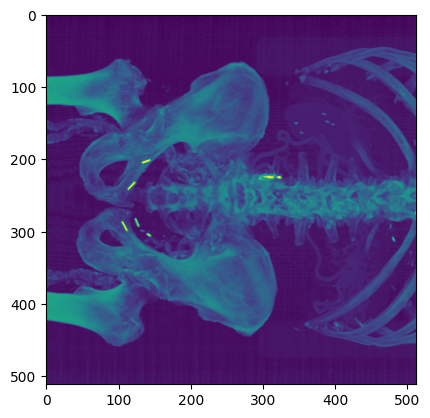

In [133]:
plt.imshow(volume_2d.squeeze())
plt.show()

In [135]:
volume_2d = volume_2d.numpy()
volume_2d.dtype

dtype('int16')

In [171]:
def patches(image):
    demo_dict = []
    image = image.squeeze()
    patches = patchify(image.numpy(), (64,64), step=64)
        
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            single_patch_img = patches[i,j,:,:]
            demo_dict.append(single_patch_img)
    return demo_dict

In [172]:
patch1 = patches(volume_2d)

In [178]:
len(patch1)

64

In [176]:
patch1[15].shape

(64, 64)

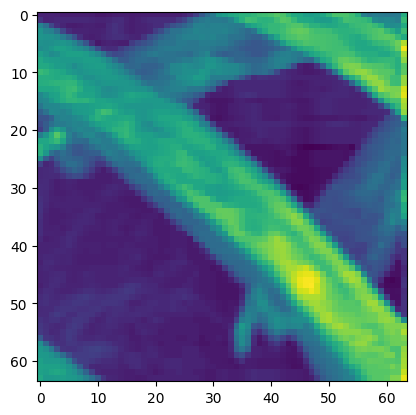

In [177]:
plt.imshow(patch1[15])

## Set deterministic seed for reproducibility

In [6]:
set_determinism(seed=0)

## Section-3: Creating a custom dataset and making transforms for augmentation


In [254]:
class CustomData(torch.utils.data.Dataset):
    
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.data = []
        image_sizes = []
        
        for file in os.listdir(self.root_dir):
            if file.endswith('signal.nrrd'):
                image_id = file.split('_')[0]
                
                # reading in the images
                signal_nrrd, _ = nrrd.read(os.path.join(self.root_dir, file))
                noise_nrrd, _ = nrrd.read(os.path.join(self.root_dir, f"{image_id}_noise.nrrd"))
                std_nrrd, _ = nrrd.read(os.path.join(self.root_dir, f"{image_id}_std.nrrd"))

                # converting to 2D Axial
                signal = np.max(signal_nrrd, axis=1)
                noise = np.max(noise_nrrd, axis=1)
                std = np.max(std_nrrd, axis=1)
                
                # converting to tensor and resizing to 512,512 for uniformity
                trans = transforms.Compose([transforms.ToTensor(), 
                                           transforms.Resize((512,512))])
                                           #transforms.Normalize(mean=[0.5], std=[0.5]])
                signal = trans(signal)
                noise = trans(noise)
                std = trans(std)
                
                # generating input image fromm signal and noise
                k = random.uniform(0,5)
                ct_generated = signal + (k*noise)
                
                # generating patches
                ct_patches = patches(ct_generated)
                std_patches = patches(std)
                #print(len(ct_patches), len(std_patches))
                
                # storing the new dataset in a dictionary
                for i in range(len(ct_patches)):
                    self.data.append({'ct_generated' : ct_patches[i], 'std_map' : std_patches[i]})
                
                
    def data_info(self, idx):
        item = self.data[idx]
        ct_gen = item['ct_generated']
        std_ma = item['std_map']

        # Print the index of the data item
        print(f"Data item {idx}:")

        # Print the shape of the ct_generated tensor
        print(f"ct_generated shape: {ct_gen.shape}")

        # Print the shape of the std_map tensor
        print(f"std_map shape: {std_ma.shape}")

        print()
            
            
    def plot_ct(self, idx):
        item = self.data[idx]
        ct_generated = item['ct_generated']
        std_map = item['std_map']
        
        # Create a figure
        plt.figure(figsize=(5,5))
        
        # Plot axial view of ct_generated
        plt.subplot(1, 2, 1)
        plt.imshow(ct_generated, cmap='gray')
        plt.title('ct_generated Patch-0')
        plt.axis('off')
        
        # Plot axial view of std_map
        plt.subplot(1, 2, 2)
        plt.imshow(std_map, cmap='hot')
        plt.title('std_map Patch-0')
        plt.axis('off')
        
        # Show the plots
        plt.show()

            
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        item = self.data[idx]
        return item
    
    
    def patches(image):
        demo_dict = []
        image = image.squeeze()
        patches = patchify(image.numpy(), (64,64), step=64)

        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                single_patch_img = patches[i,j,:,:]
                demo_dict.append(single_patch_img)
        return demo_dict

In [255]:
custom_dataset = CustomData(root_dir = data_dir)

In [256]:
len(custom_dataset)

640

In [257]:
custom_dataset.data_info(5)

Data item 5:
ct_generated shape: (64, 64)
std_map shape: (64, 64)



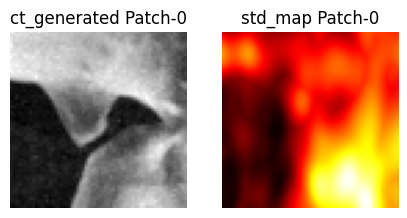

In [244]:
custom_dataset.plot_ct(8)

In [258]:
train_files, remaining_files = train_test_split(custom_dataset, test_size=0.2, random_state=42)
val_files, test_files = train_test_split(remaining_files, test_size=0.5, random_state=42)

print(len(train_files), len(val_files), len(test_files))

512 64 64


In [322]:
# transforms for data augmentation and refining

train_transforms = transforms.Compose([
    ScaleIntensityd(keys = ['ct_generated', 'std_map']), 
    RandRotated(keys = ['ct_generated', 'std_map'], range_x=(-np.pi/12, np.pi/12), prob = 0.5, keep_size = True), 
    RandFlipd(keys = ['ct_generated', 'std_map'], spatial_axis = 0, prob = 0.5), 
    RandZoomd(keys = ['ct_generated', 'std_map'], zoom = (0.9,1.1), prob = 0.5) 
])

val_transforms = transforms.Compose([
    ScaleIntensityd(keys = ['ct_generated', 'std_map']) 
])

In [277]:
# transforms for data augmentation and refining

train_transforms = v2.Compose([v2.RandomHorizontalFlip(p=0.5),
                            v2.RandomVerticalFlip(p=0.5),
                            v2.RandomRotation(30),
                            v2.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
                            v2.ToDtype(torch.float32, scale=True),
                            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = v2.Compose([v2.RandomHorizontalFlip(p=0.5),
                             v2.RandomVerticalFlip(p=0.5),
                            v2.RandomRotation(30),
                            v2.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
                            v2.ToDtype(torch.float32, scale=True),
                            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Section-4: Data Loader

In [323]:
## Complete your code here
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1, collate_fn=pad_list_data_collate)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=1, collate_fn=pad_list_data_collate)

Loading dataset: 100%|██████████| 64/64 [00:00<00:00, 30982.86it/s]


## Section-5: UNet Training and Testing

In [324]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv_op(x)
    
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self,x):
        down = self.conv(x)
        p = self.pool(down)
        
        return down, p
    
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1,x2],1)
        
        return self.conv(x)   

In [325]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.down_convolution1 = DownSample(in_channels, 64)
        self.down_convolution2 = DownSample(64, 128)
        self.down_convolution3 = DownSample(128, 256)
        self.down_convolution4 = DownSample(256, 512)
        
        self.bottleneck = DoubleConv(512, 1024)
        
        self.up_convolution1 = UpSample(1024, 512)
        self.up_convolution2 = UpSample(512, 256)
        self.up_convolution3 = UpSample(256, 128)
        self.up_convolution4 = UpSample(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)
        
        
    def forward(self, x):
        down1, p1 = self.down_convolution1(x)
        down2, p2 = self.down_convolution2(p1)
        down3, p3 = self.down_convolution3(p2)
        down4, p4 = self.down_convolution4(p3)
        
        b = self.bottleneck(p4)
        
        up1 = self.up_convolution1(b, down4)
        up2 = self.up_convolution2(up1, down3)
        up3 = self.up_convolution3(up2, down2)
        up4 = self.up_convolution4(up3, down1)
        
        out = self.out(up4)
        
        return out
        

In [326]:
# initializing the model and optimizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet(in_channels = 1, num_classes = 1024).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
model_saving_path = '/projectnb/ec500kb/projects/Project6/'

In [327]:
# LOSS Function - Average Relative Error
def average_relative_error(output, target):
    # Avoid division by zero
    nonzero_mask = target != 0
    return torch.mean(torch.abs((output[nonzero_mask] - target[nonzero_mask]) / target[nonzero_mask]))

In [328]:
# training and validation

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_val_loss = 0.0
    model.train()  # Ensure the model is in training mode

    for idx, images in enumerate(tqdm(train_loader)):
        img = images['ct_generated'].float().to(device)
        std_map = images['std_map'].float().to(device)
        
        optimizer.zero_grad()
        y_pred = model(img)
        loss = average_relative_error(y_pred, std_map)
        #loss = criterion(y_pred, std_map)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for idx, image in enumerate(tqdm(val_loader)):
            img = image['ct_generated'].float().to(device)
            std_map = image['std_map'].float().to(device)

            y_pred = model(img)
            val_loss = average_relative_error(y_pred, std_map)
            #val_loss = criterion(y_pred, std_map)
            running_val_loss += val_loss.item() * img.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

  0%|          | 0/512 [00:00<?, ?it/s]


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr4/ece601/avantk/.local/lib/python3.10/site-packages/monai/transforms/transform.py", line 141, in apply_transform
    return _apply_transform(transform, data, unpack_items, lazy, overrides, log_stats)
  File "/usr4/ece601/avantk/.local/lib/python3.10/site-packages/monai/transforms/transform.py", line 98, in _apply_transform
    return transform(data, lazy=lazy) if isinstance(transform, LazyTrait) else transform(data)
  File "/usr4/ece601/avantk/.local/lib/python3.10/site-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
  File "/usr4/ece601/avantk/.local/lib/python3.10/site-packages/monai/transforms/spatial/dictionary.py", line 1882, in __call__
    d[key] = self.rand_rotate(
  File "/usr4/ece601/avantk/.local/lib/python3.10/site-packages/monai/transforms/spatial/array.py", line 1381, in __call__
    out = rotator(img)
  File "/usr4/ece601/avantk/.local/lib/python3.10/site-packages/monai/transforms/spatial/array.py", line 956, in __call__
    return rotate(  # type: ignore
  File "/usr4/ece601/avantk/.local/lib/python3.10/site-packages/monai/transforms/spatial/functional.py", line 370, in rotate
    raise ValueError(f"Unsupported image dimension: {input_ndim}, available options are [2, 3].")
ValueError: Unsupported image dimension: 1, available options are [2, 3].

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr4/ece601/avantk/.local/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr4/ece601/avantk/.local/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr4/ece601/avantk/.local/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr4/ece601/avantk/.local/lib/python3.10/site-packages/monai/data/dataset.py", line 112, in __getitem__
    return self._transform(index)
  File "/usr4/ece601/avantk/.local/lib/python3.10/site-packages/monai/data/dataset.py", line 934, in _transform
    data = self.transform(data, start=first_random)
  File "/usr4/ece601/avantk/.local/lib/python3.10/site-packages/monai/transforms/compose.py", line 335, in __call__
    result = execute_compose(
  File "/usr4/ece601/avantk/.local/lib/python3.10/site-packages/monai/transforms/compose.py", line 111, in execute_compose
    data = apply_transform(
  File "/usr4/ece601/avantk/.local/lib/python3.10/site-packages/monai/transforms/transform.py", line 171, in apply_transform
    raise RuntimeError(f"applying transform {transform}") from e
RuntimeError: applying transform Compose(
    <monai.transforms.intensity.dictionary.ScaleIntensityd object at 0x15114fa8e320>
    <monai.transforms.spatial.dictionary.RandRotated object at 0x15114fa8ec20>
    <monai.transforms.spatial.dictionary.RandFlipd object at 0x15114fa994b0>
    <monai.transforms.spatial.dictionary.RandZoomd object at 0x15114fa99420>
)


## Section-6: RATUNet Training and Testing

In [308]:
class RatUNet(nn.Module):
    def __init__(self, block, num_features=64):
        super(RatUNet, self).__init__()
        self.inplanes = num_features
        
        self.conv = nn.Conv2d(1, num_features, kernel_size=3, stride=1, padding=1, bias=True)

        self.layer1 = self._make_layer(block, 64, 128, 3, stride=2)
        self.layer2 = self._make_layer(block, 128, 256, 3, stride=2)

        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.layer3 = self._make_layer(block, 256, 512, 4, stride=2)
        self.deconv2 = nn.ConvTranspose2d(512, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)

        self.layer4 = self._make_layer(block, 256, 256, 3)
        self.layer5 = self._make_layer(block, 128, 128, 3)
        self.layer6 = self._make_layer(block, 128, 128, 2)
        self.conv2 = nn.Sequential(nn.Conv2d(192, 128, kernel_size=3, stride=1, padding=1, bias=True),
                                   nn.PReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True),
                                   nn.PReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True),
                                   nn.PReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, groups=128, bias=True),
                                   nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0, bias=True),
                                   nn.ReLU(inplace=True),
                                   )
        self.ca = SequentialPolarizedSelfAttention(128)
        self.lastconv = nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=1, bias=True)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0.0, math.sqrt(1.0 / n))
                m.bias.data.zero_()

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        layers = []
        downsample = None
        self.inplanes = inplanes
        if stride != 1:
            downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, bias=True),
                    nn.AvgPool2d(kernel_size=2, stride=stride),
            )
#        if  stride == 1 and self.inplanes == 2*planes:
#            downsample = nn.Sequential(
#                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, bias=True),
#                #nn.BatchNorm2d(planes)
#            )
        
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        
        res = self.conv(x)

        res2 = self.layer1(res)
        res3 = self.layer2(res2)        
        out = self.layer3(res3)
        
        out = self.deconv1(out)               
        out = self.layer4(out)
        out = torch.cat((out, res3), dim=1) 

        out = self.deconv2(out)        
        out = self.layer5(out)
        out = torch.cat((out, res2), dim=1)
        
        out = self.deconv3(out)        
        out = self.layer6(out)
        out = torch.cat((out, res), dim=1)
        
        out = self.conv2(out)
        out = self.ca(out)
        out = self.lastconv(out)
        
        return x - out


In [309]:
class BasicBlock(nn.Module):
    expansion=1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride = stride, padding=1, bias=True)
        #self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.PReLU()#.LeakyReLU(0.2, inplace=True)# nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride = 1, padding=1, bias=True)
        #self.conv3 = nn.Conv2d(planes, planes, kernel_size=1, stride = 1, padding=0, bias=True)

        self.downsample = downsample
        #self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        #out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)        
        
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual      
        out = self.relu(out)

        return out


In [310]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=True),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=True))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class SequentialPolarizedSelfAttention(nn.Module):

    def __init__(self, channel=512):
        super().__init__()
        self.ch_wv=nn.Conv2d(channel,channel//2,kernel_size=(1,1))
        self.ch_wq=nn.Conv2d(channel,1,kernel_size=(1,1))
        self.softmax_channel=nn.Softmax(1)
        self.softmax_spatial=nn.Softmax(-1)
        self.ch_wz=nn.Conv2d(channel//2,channel,kernel_size=(1,1))
        self.ln=nn.LayerNorm(channel)
        self.sigmoid=nn.Sigmoid()
        self.sp_wv=nn.Conv2d(channel,channel//2,kernel_size=(1,1))
        self.sp_wq=nn.Conv2d(channel,channel//2,kernel_size=(1,1))
        self.agp=nn.AdaptiveAvgPool2d((1,1))

    def forward(self, x):
        b, c, h, w = x.size()

        #Channel-only Self-Attention
        channel_wv=self.ch_wv(x) #bs,c//2,h,w
        channel_wq=self.ch_wq(x) #bs,1,h,w
        channel_wv=channel_wv.reshape(b,c//2,-1) #bs,c//2,h*w
        channel_wq=channel_wq.reshape(b,-1,1) #bs,h*w,1
        channel_wq=self.softmax_channel(channel_wq)
        channel_wz=torch.matmul(channel_wv,channel_wq).unsqueeze(-1) #bs,c//2,1,1
        channel_weight=self.sigmoid(self.ch_wz(channel_wz).reshape(b,c,1).permute(0,2,1)).permute(0,2,1).reshape(b,c,1,1) #bs,c,1,1self.ln(
        channel_out=channel_weight*x

        #Spatial-only Self-Attention
        spatial_wv=self.sp_wv(channel_out) #bs,c//2,h,w
        spatial_wq=self.sp_wq(channel_out) #bs,c//2,h,w
        spatial_wq=self.agp(spatial_wq) #bs,c//2,1,1
        spatial_wv=spatial_wv.reshape(b,c//2,-1) #bs,c//2,h*w
        spatial_wq=spatial_wq.permute(0,2,3,1).reshape(b,1,c//2) #bs,1,c//2
        spatial_wq=self.softmax_spatial(spatial_wq)
        spatial_wz=torch.matmul(spatial_wq,spatial_wv) #bs,1,h*w
        spatial_weight=self.sigmoid(spatial_wz.reshape(b,1,h,w)) #bs,1,h,w
        spatial_out=spatial_weight*channel_out
        return spatial_out


In [311]:
# Model and optimizer initialization
device = "cuda" if torch.cuda.is_available() else "cpu"
model = RatUNet(BasicBlock, 64).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#criterion = nn.MSELoss()
#criterion = nn.L1Loss()
model_saving_path = '/projectnb/ec500kb/projects/Project6/RatUNet.pth'

# Train the model
total_step = len(train_loader)
num_epochs = 300
best_val_loss = float('inf')  # Initialize best validation loss for model saving

In [312]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_val_loss = 0.0
    model.train()  # Ensure the model is in training mode

    for idx, images in enumerate(tqdm(train_loader)):
        img = images['ct_generated'].float().to(device)
        std_map = images['std_map'].float().to(device)
        
        optimizer.zero_grad()
        y_pred = model(img)
        loss = average_relative_error(y_pred, std_map)
        #loss = criterion(y_pred, std_map)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for idx, image in enumerate(tqdm(val_loader)):
            img = image['ct_generated'].float().to(device)
            std_map = image['std_map'].float().to(device)

            y_pred = model(img)
            val_loss = average_relative_error(y_pred, std_map)
            #val_loss = criterion(y_pred, std_map)
            running_val_loss += val_loss.item() * img.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")


  0%|          | 0/512 [00:01<?, ?it/s]


RuntimeError: Given transposed=1, weight of size [512, 128, 3, 3], expected input[1, 256, 32, 16] to have 512 channels, but got 256 channels instead

## Section-7: Uncertainty Estimation